# Load Levels

In [1]:
levels = [open(f"levels/level{i+1}.txt", "r").readline().strip() for i in range(10)]

# Customize Game Class

In [2]:
from game import Game

RIGHT_DIRECT_MOVE = "0"
RIGHT_JUMP__MOVE = "1"
RIGHT_DODGE_MOVE = "2"

BLANKK = "_"
GOOMPA = "G"
LAKIPO = "L"
MUSHRM = "M"


class MoveModel:
    def __init__(self, current_step, prev_action, before_prev_action, addition):
        self.current_step = current_step
        self.prev_action = prev_action
        self.before_prev_action = before_prev_action
        self.addition = addition


class MyGame(Game):
    def generate_move_rules(
        self,
        step_score=1,
        bonus_score=2,
        enemy_encounter_score=2,
        jump_penalty=0.2,
    ):
        return [
            MoveModel(BLANKK, RIGHT_DODGE_MOVE, None, +step_score),
            # MoveModel(BLANKK, RIGHT_JUMP__MOVE, None, +step_score - jump_penalty),
            MoveModel(BLANKK, RIGHT_JUMP__MOVE, RIGHT_DODGE_MOVE, +step_score - jump_penalty),
            MoveModel(BLANKK, RIGHT_JUMP__MOVE, RIGHT_JUMP__MOVE, +step_score),
            MoveModel(BLANKK, RIGHT_JUMP__MOVE, RIGHT_DIRECT_MOVE, +step_score - jump_penalty),
            MoveModel(BLANKK, RIGHT_DIRECT_MOVE, None, +step_score),

            MoveModel(MUSHRM, RIGHT_DODGE_MOVE, None, +bonus_score),
            # MoveModel(MUSHRM, RIGHT_JUMP__MOVE, None, +step_score),
            MoveModel(MUSHRM, RIGHT_JUMP__MOVE, RIGHT_DODGE_MOVE, +step_score),
            MoveModel(MUSHRM, RIGHT_JUMP__MOVE, RIGHT_JUMP__MOVE, +bonus_score),
            MoveModel(MUSHRM, RIGHT_JUMP__MOVE, RIGHT_DIRECT_MOVE, +step_score),
            MoveModel(MUSHRM, RIGHT_DIRECT_MOVE, None, +bonus_score),
            
            MoveModel(GOOMPA, None, RIGHT_JUMP__MOVE, +step_score + enemy_encounter_score),
            # MoveModel(GOOMPA, RIGHT_JUMP__MOVE, None, +step_score),
            MoveModel(GOOMPA, RIGHT_JUMP__MOVE, RIGHT_DODGE_MOVE, +step_score),
            MoveModel(GOOMPA, RIGHT_JUMP__MOVE, RIGHT_DIRECT_MOVE, +step_score),
            
            MoveModel(LAKIPO, RIGHT_DODGE_MOVE, None, +step_score),
        ]

    # modified score function
    def get_score(
        self,
        actions,
        honor_score=1,
        win_score=5,
        lose_penalty=0,
        is_lose_seq_continue_accepted=True,
    ):
        model = self.generate_move_rules()
        current_level = self.levels[self.current_level_index]
        won = True
        score = 0  # previously named step
        for step in range(self.current_level_len - 1):
            current_step = current_level[step]
            flag = False
            for move in model:
                if move.current_step == current_step:
                    if (
                        move.prev_action == actions[step - 1]
                        or move.prev_action == None
                        or step < 1
                    ):
                        if (
                            move.before_prev_action == actions[step - 2]
                            or move.before_prev_action == None
                            or step < 2
                        ):
                            score += move.addition
                            flag = True
            # lose state
            if not flag:
                won = False
                score -= lose_penalty
                if is_lose_seq_continue_accepted:
                    continue
                else:
                    break
        # honorable win
        if won and actions[len(current_level) - 1] == RIGHT_JUMP__MOVE:
            score += honor_score

        return won, score + (win_score if won else 0)

    # bulk running utilities
    def get_score_for_next(self, move):
        self.load_next_level()
        return self.get_score(move)

    def get_score_for_each(self, move_list):
        self.current_level_index = -1
        self.current_level_len = 0
        scores = [self.get_score_for_next(move) for move in move_list]
        return scores

(False, 4)


# Initialization

In [3]:
import random
import numpy as np


def generate_random_string(length, possible_actions="012"):
    """randomly generates a sequence of given possible_actions

    default actions express equal chance of presence for each action in random solution

    e.g. you can pass "0012" for double chance of direct move presence in random solution
    """
    return "".join(random.choice(possible_actions) for i in range(length))


INIT_POPULATION_SIZE = 500
population = np.array(
    [
        [generate_random_string(len(l)) for l in levels]
        for i in range(INIT_POPULATION_SIZE)
    ]
)

# Selection

In [4]:
import math

def round_wheel_selection(inputs, scores):
    selected_inputs = []
    selected_scores = []
    points = [random.randint(0, int(sum(scores) - 1)) for i in range(math.ceil(len(inputs) / 2))]
    progressive_sum = 0
    for i in range(len(inputs)):
        for point in points:
            if point >= progressive_sum and point < progressive_sum + scores[i]:
                selected_inputs.append(inputs[i])
                selected_scores.append(scores[i])
        progressive_sum += scores[i]
    return selected_inputs, selected_scores


def fitness_based_selection(inputs, scores):
    sorted_inputs, sorted_scores = zip(
        *sorted(list(zip(inputs, scores)), key=lambda x: x[1])
    )
    return sorted_inputs[len(inputs) // 2 :], sorted_scores[len(sorted_scores) // 2 :]


# test
print("round_wheel_selection", round_wheel_selection(["111", "222", "000"], [1, 2, 3]))
print("fitness_based_selection", fitness_based_selection(["111", "222", "000"], [1, 2, 3]))

round_wheel_selection (['222', '000'], [2, 3])
fitness_based_selection (('222', '000'), (2, 3))


# Recombination

In [5]:
def crossover(parents, points):
    points = sorted(points)
    # the last point is a helper expressing the end of chromosome(not last gene!)
    points.append(len(parents[0])) if points[-1] != len(parents[0]) else None
    offsprings = list(parents)
    last_point_ind = 0
    for round in range(len(points)):
        # if points be more that parents
        start_parent_ind = round % len(parents)

        for child_ind in range(len(offsprings)):
            parent_ind = (child_ind + start_parent_ind) % len(parents)
            offsprings[child_ind] = (
                offsprings[child_ind][:last_point_ind]
                + parents[parent_ind][last_point_ind : points[round]]
                + parents[child_ind][points[round] :]
            )
        last_point_ind = points[round]
    return offsprings

# test
print("one point", crossover(["111", "222", "000"],[1]))
print("two point", crossover(["111", "222", "000"],[1,2]))

one point ['122', '200', '011']
two point ['120', '201', '012']


# Mutation

In [6]:
def mutate_each_gene(chrom_lst, mut_prob=0.2, actions="00012"):
    for chrom_ind in range(len(chrom_lst)):
        for gene_ind in range(len(chrom_lst[chrom_ind])):
            if random.random() <= mut_prob:
                chrom_lst[chrom_ind] = (
                    chrom_lst[chrom_ind][:gene_ind]
                    + random.choice(actions)
                    + chrom_lst[chrom_ind][gene_ind + 1 :]
                )
    return chrom_lst


def mutate_random_gene(chrom_lst, mut_prob=0.2, actions="00012", try_times=1):
    for chrom_ind in range(len(chrom_lst)):
        if random.random() <= mut_prob:
            for try_time in range(try_times):
                gene_ind = random.randint(0, chrom_ind - 1) if chrom_ind != 0 else 0
                chrom_lst[chrom_ind] = (
                    chrom_lst[chrom_ind][:gene_ind]
                    + random.choice(actions)
                    + chrom_lst[chrom_ind][gene_ind + 1 :]
                )
    return chrom_lst


# test
print("mutate_each_gene", mutate_each_gene(["111", "222"]))
print("mutate_random_gene", mutate_random_gene(["111", "222"]))

mutate_each_gene ['111', '022']
mutate_random_gene ['111', '222']


# Stop Criterion

In [7]:
EPSILON = 0.0001
MAX_GENRATION = 30
def check_stop_criterion(generation_number, mean_dif):
    return generation_number >= MAX_GENRATION or mean_dif <= EPSILON
    

In [8]:
import numpy as np

g = MyGame(levels)
level = 8


score_mean = []
score_max = []
score_min = []
gn = 0
prev_population = population  # for after uses
while not check_stop_criterion(
    gn, abs(score_mean[-2][level - 1] - score_mean[-1][level - 1]) if gn > 1 else 999999
):
    # bulk running
    scores = np.array([g.get_score_for_each(pop) for pop in population])
    # selection
    sel_pop, sel_scores = round_wheel_selection(
        population[:, level - 1], scores[:, level - 1, 1]
    )
    # recombin
    off_springs = crossover(sel_pop, [len(sel_pop[0]) // 3, 2 * len(sel_pop[0]) // 3])
    # mutation
    # mutated_offsprings = mutate_each_gene(off_springs)
    mutated_offsprings = mutate_random_gene(off_springs, try_times=2, mut_prob=0.5)
    # next gen
    present_parents, _ = fitness_based_selection(
        population[:, level - 1], scores[:, level - 1, 1]
    )
    prev_population = np.copy(population)
    population[:, level - 1] = mutated_offsprings + list(present_parents)
    gn += 1
    score_mean.append(
        np.mean(
            [[result[1] for result in sample] for sample in scores], axis=0
        ).reshape(-1, 1)
    )
    score_max.append(
        np.max([[result[1] for result in sample] for sample in scores], axis=0).reshape(
            -1, 1
        )
    )
    score_min.append(
        np.min([[result[1] for result in sample] for sample in scores], axis=0).reshape(
            -1, 1
        )
    )

# Diagrams

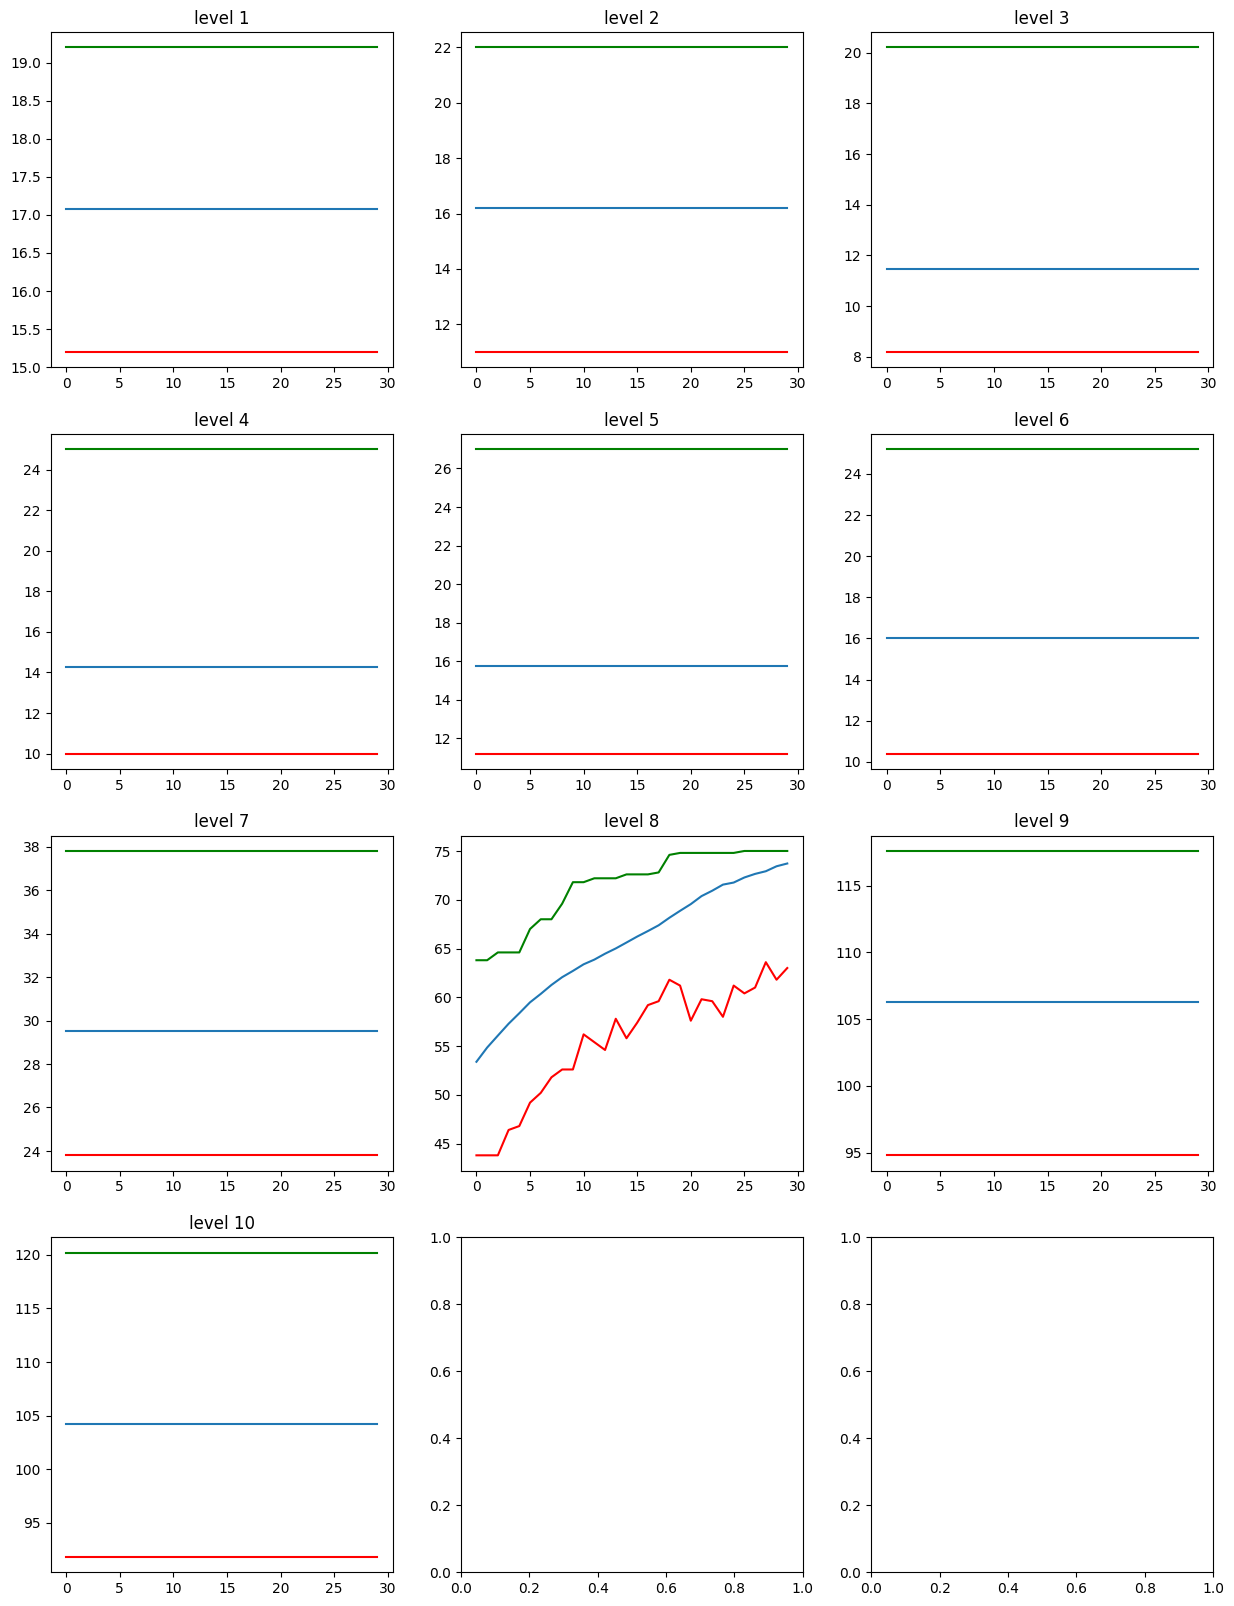

In [9]:
from matplotlib import pyplot as plt
import numpy as np

score_mean = np.array(score_mean)
score_max = np.array(score_max)
score_min = np.array(score_min)

fig, ax = plt.subplots(4, 3, figsize=(15, 20))

ln = 1
for j in range(4):
    for i in range(3):
        ax[j, i].plot(score_mean[:, ln - 1])
        ax[j, i].plot(score_min[:, ln - 1],'r')
        ax[j, i].plot(score_max[:, ln - 1],'g')
        ax[j, i].set_title(f"level {ln}")
        ln += 1
        if ln > 10: break
plt.show()

# last generation complete answers

In [10]:
ls = scores[:, level - 1]
print(ls.shape)
fls = filter(lambda s: s[1][0] == True, zip(prev_population[:, level - 1], ls))
list(fls)

(500, 2)


[('02121100011002002010111011011122102021100112201100002', array([ 1., 68.])),
 ('001010110012021120101121112112221000211010012022120002',
  array([ 1. , 70.2])),
 ('1210110001112220201012211121112210002111222222200001020',
  array([ 1. , 71.8])),
 ('001011222011022020101121112111221011211122222220000222000',
  array([ 1. , 70.8])),
 ('11101102200102202010112111211120100121112222222000022',
  array([ 1. , 72.6])),
 ('00100122201102222012112112222122100121112222222000022100',
  array([ 1., 69.])),
 ('11101102201102222012112112222122100221112222222000102100',
  array([ 1. , 72.8])),
 ('11101100200122202010112111211122110021101001202212000022',
  array([ 1. , 72.4])),
 ('11102100200122202102011100112020100021101001202212001022',
  array([ 1. , 72.6])),
 ('1212110001112220201211211222212210002110200120221200000',
  array([ 1. , 71.6])),
 ('011011212001022120111121112111221000211010012022120020000',
  array([ 1. , 69.6])),
 ('11101102200102202012112112221122100121112022222000020',
  array([

In [12]:
g = MyGame(['____G_G_MMM___L__L_G_____G___M_L__G__L_GM____L____'])
g.load_next_level()
g.get_score('111011022002022021000111001120201111211122222220000000')

(True, 74.99999999999999)